# Задание **Ultra Lite**

Перепишите вариационный автокодировщик на базе Mnist с нуля в новом ноутбуке. Можно подсматривать в ноутбук занятия, но лучше писать код своими руками, а не копировать.

# Подключение библиотек

In [ ]:
!pip install keras==2.0 -q            # Для корректной работы загружаем эту версию кераса
!pip install tensorflow==1.13.0rc1 -q # Так же для tensorflow


     |████████████████████████████████| 191 kB 5.3 MB/s 
     |████████████████████████████████| 454.4 MB 9.6 kB/s 
     |████████████████████████████████| 1.2 MB 38.2 MB/s 
     |████████████████████████████████| 4.0 MB 39.4 MB/s 
     |████████████████████████████████| 462 kB 50.5 MB/s 
     |████████████████████████████████| 92.7 MB 43 kB/s 
     |████████████████████████████████| 367 kB 39.7 MB/s 
     |████████████████████████████████| 3.0 MB 41.4 MB/s 
     |████████████████████████████████| 50 kB 6.9 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kapre 0.3.5 requires tensorflow>=2.0.0, but you have tensorflow 1.13.0rc1 which is incompatible.
  Created wheel for snoop: filename=snoop-0.4.0-py3-none-any.whl size=27364 sha256=88025ff38478f62ec884fd2cbdbe9592fbc16bda0aa26a10b60f6641397ffcfb
  Stored in directory: /root/.cache/pip/wheels/ab/52/15/6e958

In [ ]:
from tensorflow.keras.models import Model                                        # Абстрактный класс базовой модели сети от keras
from tensorflow.keras.layers import Input, Dense, Dropout, Reshape, Lambda       # Загружаем слои
from tensorflow.keras.layers import Flatten, BatchNormalization, Conv2DTranspose # Загружаем слои
from tensorflow.keras.layers import LeakyReLU, concatenate, Conv2D               # Загружаем слои
from tensorflow.keras.optimizers import Adam                                     # Оптимизатор
from tensorflow.keras.losses import binary_crossentropy                          # Функция потерь
from tensorflow.keras.datasets import mnist                                      # Готовая база рукописных цифр
from tensorflow.keras import backend as K                                        # Устанавливаем переменную для окружения keras
from tensorflow.keras.callbacks import LambdaCallback, ReduceLROnPlateau         # Импортируем callback
from tensorflow.keras.callbacks import TensorBoard                               # Импортируем еще один callback
from tensorflow.keras.utils import plot_model, to_categorical                    # Визуализация модели нейронной сети

from IPython.display import clear_output                                         # Модуль очистки ячейки 
from scipy.stats import norm, multivariate_normal                                # Модуль с нормальным непрерывными непрерывными случайными величинами


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

In [ ]:
# Подключим диск для сохранения весов после обучения моделей
# from google.colab import drive
# drive.mount('/content/drive/')

# VAE (Вариационный автокодировщик)

## Загрузка данных

In [ ]:
(xTrain, yTrain), (xTest, yTest) = mnist.load_data()    # Загружаем данные mnist c разбивкой

11493376/11490434 [==============================] - 0s 0us/step


## Нормализация

In [ ]:
# Значения от 0 до 1
xTrain = xTrain.astype('float32') / 255     
xTest = xTest.astype('float32') / 255

# Меняем форму и приводим к нужным размерам
xTrain = np.reshape(xTrain, (len(xTrain), 28, 28, 1))
xTest = np.reshape(xTest, (len(xTest), 28, 28, 1))

print(xTrain.shape)
print(xTest.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


## Создание функций и моделей

In [ ]:
# Зададим константы
batch_size = 100      # Размер batch_size
latent_dim = 10       # Размер скрытого пространства
dropout_rate = 0.3    # Размер слоя Dropount, сколько выключаем нейронов
start_lr = 0.0001     # Задаем шаг обучения

In [ ]:
pip install snoop

In [ ]:
# Функция создания вариационного автокодировщика
def create_vae():
  models = {}                                              # Задаем словарь моделей

  # Функция Dropout и BatchNormalization
  def apply_dn_and_dropout(x):                             # На вход принимает слой (x)
    return Dropout(dropout_rate)(BatchNormalization()(x))  # Возвращает 2 слоя

  # Энкодер
  input_img = Input(batch_shape=(batch_size, 28, 28, 1))   # Размерность входных данных (батч, строки, столбцы, фильты)
  x = Flatten()(input_img)                                 # Слой выравнивания
  x = Dense(256, activation='relu')(x)                     # Полносвязный слой на 256 нейронов
  x = apply_dn_and_dropout(x)                              # Применяем функцию добавления слоев регуляризации/нормализации
  x = Dense(128, activation='relu')(x)                     # Полносвязный слой на 128 нейронов
  x = apply_dn_and_dropout(x)                              # Применяем функцию добавления слоев регуляризации/нормализации

  # Предсказываем логарифм вариации вместо стандартного отклонения

  z_mean = Dense(latent_dim)(x)                            # Скрытое пространство(математическое ожидание) размером 10
  z_log_var = Dense(latent_dim)(x)                         # Скрытое пространство(логарифм вариации) размером 10

  
  # Сэмплирование из Q с трюком репараметризации

  def sampling(args):                                  # Объявляем функцию сэмплирования
    z_mean, z_log_var = args                           # принимаем в аргументах z_mean, z_log_var

    # Методом из keras делаем нормальное распределение(500 10тимерных), мат.ожидание 0, ст.отклонение 1
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.0)
    return z_mean + K.exp(z_log_var / 2) * epsilon
  
  # Задаем самописный слой
  l = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

  models["encoder"] = Model(input_img, l)              # Модель энкодера от входа до лямда слоя
  models["z_meaner"] = Model(input_img, z_mean)        # Модель от входа до z_mean
  models["z_lvarer"] = Model(input_img, z_log_var)     # Модель от входа до Z_log_var

  # Декодер

  z = Input(shape=(latent_dim, ))                      # Задаем входную размерность (10,)
  x = Dense(128)(z)                                    # Полносвязный слой на 128 нейронов
  x = LeakyReLU()(x)                                   # Функция активации отдельными слоем
  x = apply_dn_and_dropout(x)                          
  x = Dense(256)(x)                                    # Полносвязный слой на 256 нейронов
  x = LeakyReLU()(x)
  x = apply_dn_and_dropout(x)
  x = Dense(28*28, activation='sigmoid')(x)            # Полносвязный слой на 784 нейронов

  decoded = Reshape((28, 28, 1))(x)                    # Меняемформу для нужного размера

  models["decoder"] = Model(z, decoded, name='Decoder')

  # Cобираем вариационный автокодировщик
  models["vae"] = Model(input_img, models["decoder"](models["encoder"](input_img)), name="VAE")

  # Cамописная функция потерь
  def vae_loss(x, decoded): 
    x = K.reshape(x, shape=(batch_size, 28*28))                                           # Меняем размеры в одномерный x
    decoded = K.reshape(decoded, shape=(batch_size, 28*28))                               # Меняем размеры в одномерный decoded
    xent_loss = 28 * 28 * binary_crossentropy(x, decoded)                                 # Бинарную кроссэнтропию между x и decoded, с учетом пикселей
    kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)  # По формуле устанавливаем ошибку kl_loss
    return (xent_loss + kl_loss) / 2 / 28 / 28                                            # Возврат суммы ошибки с учетом распределения и размеров пикселей
  
  return models, vae_loss

In [ ]:
# Получаем модели(словарь) и свою функцию потерь

models, vae_loss = create_vae()

In [ ]:
# Задаем модель вариационного автокодировщика
vae = models["vae"]
vae.compile(optimizer=Adam(start_lr), loss=vae_loss)

In [ ]:
# Функция отрисовки двух линий картинок - оригинальные и выходные из автокодировщика

digit_size = 28   # Задаем размер цифр

def plot_digits(*args, invert_colors=False):
  args = [x.squeeze() for x in args]                          # Удаляем оси с одним элементом из аргументов
  n = min([x.shape[0] for x in args])                         # Берем минимальное от нулевой оси x'ов в аргументах
  figure = np.zeros((digit_size * len(args), digit_size * n)) # Cоздаем фигуру с использованием массива нулей по заданным размерам

  for i in range(n):
    for j in range(len(args)):                                # Заполняем фигуру значениями
      figure[j * digit_size: (j + 1) * digit_size,
             i * digit_size: (i + 1) * digit_size] = args[j][i].squeeze()
  
  if invert_colors:                                           # Если значение invert_colors будет True
    figure = 1 - figure                                       # Инвертируем фигуру
  
  plt.figure(figsize=(2*n, 2*len(args)))                      # Задаем фигуру
  plt.imshow(figure, cmap='Greys_r')                          # Вывод в указанном цвете Greys_r
  plt.grid(False)                                             # Отключаем сетку
  ax = plt.gca()                                              # Получаем текущий объект Axes
  ax.get_xaxis().set_visible(False)                           # Ось координат x делаем невидимой
  ax.get_yaxis().set_visible(False)                           # Ось координат y делаем невидимой
  plt.show()

# Картинка с 15x15 цифр
n = 15 

In [ ]:
# Массивы, в которые будем сохранять результаты, для последующей визуализации
latent_distrs = []
epochs = []

In [ ]:
# Эпохи, в которые будем сохранять
save_epochs = set([i*5 for i in range(0,21)])

# Смотреть будем данные цифры
imgs = xTest[:batch_size]
n_compare = 10

# Модели
generator = models["decoder"]
encoder_mean = models["z_meaner"]

## CallBack

In [ ]:
# Функция callback после каждой эпохи
def on_epoch_end(epoch, logs):
  if epoch in save_epochs:
    clear_output()             # Очищаем выход

    # Делаем предикт (сравнение реальные и декодированные цифры)
    decoded = vae.predict(imgs, batch_size=batch_size)
    plot_digits(imgs[:n_compare], decoded[:n_compare])

    # Сохранение многообразия и распределения z для создания анимации после
    epochs.append(epoch)
    latent_distrs.append(encoder_mean.predict(xTest, batch_size))

In [ ]:
pltfig = LambdaCallback(on_epoch_end = on_epoch_end)

## Обучение

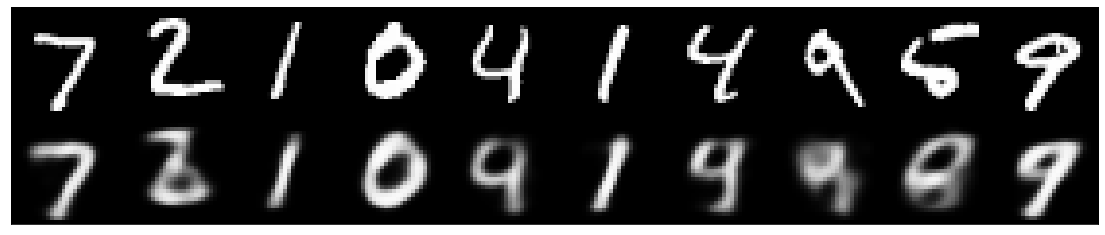

60000/60000 [==============================] - 18s 295us/sample - loss: 0.0927 - val_loss: 0.0824
Epoch 17/20
60000/60000 [==============================] - 17s 288us/sample - loss: 0.0923 - val_loss: 0.0821
Epoch 18/20
60000/60000 [==============================] - 17s 291us/sample - loss: 0.0921 - val_loss: 0.0817
Epoch 19/20
60000/60000 [==============================] - 17s 291us/sample - loss: 0.0918 - val_loss: 0.0815
Epoch 20/20
60000/60000 [==============================] - 17s 290us/sample - loss: 0.0916 - val_loss: 0.0813


In [ ]:
vae.fit(xTrain, xTrain, shuffle=True, epochs=20, batch_size=batch_size,
        validation_data=(xTest, xTest), callbacks=[pltfig], verbose=1)

In [ ]:
# Сохраним полученные веса
vae.save_weights('/content/drive/MyDrive/УИИ/Вариационные автокодировщики/Результаты/vae_ultra_lite.h5')

In [ ]:
# Функция добавляет шум на скрытом пространстве

def plot_images(generator, examples=10, dim=(10,10), figsize=(15,15)):
  k = 1.1
  noise = np.random.normal(loc=0, scale=1, size=[1,latent_dim])          # Создаем шум нормальным распределением 
  im_arr = [generator.predict((k**i)*noise) for i in range(examples)]   # Получаем сгенеренные выходные картинки над заданным шумом
  im_arr = np.array(im_arr).reshape(examples, 28, 28)                    # Переводим в numpy массив и под нужные размеры

   # Задаем способ отрисовки картинок
  plt.figure(figsize=figsize)
  for i in range(im_arr.shape[0]):
    plt.subplot(dim[0], dim[1], i+1)
    plt.imshow(im_arr[i], interpolation='nearest')
    plt.axis('off')
  plt.tight_layout()

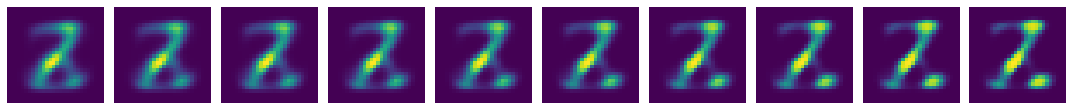

In [ ]:
# Отрисовываем картинки
plot_images(generator)

In [ ]:
# Вторая функция по отрисовке
def plot_images_two_points(generator, examples=10, dim=(10,10), figsize=(15,15)):
  noise1 = 1*np.random.normal(loc=0, scale=1, size=[1, latent_dim])                  # Первое случайное зашумленное распределение
  noise2 = 1*np.random.normal(loc=0, scale=1, size=[1, latent_dim])                  # Второе случайное зашумленное распределение

  # Получаем сгенеренные выходные картинки плавным переходом от одного зашумленного к другому 
  im_arr = [generator.predict(i*noise2/(examples-1) + (examples-i-1)*noise1/(examples-1)) for i in range(examples)]
  im_arr = np.array(im_arr).reshape(examples,28,28) 

  plt.figure(figsize=figsize)
  for i in range(im_arr.shape[0]):
    plt.subplot(dim[0], dim[1], i+1)
    plt.imshow(im_arr[i], interpolation='nearest')
    plt.axis('off')
  plt.tight_layout()

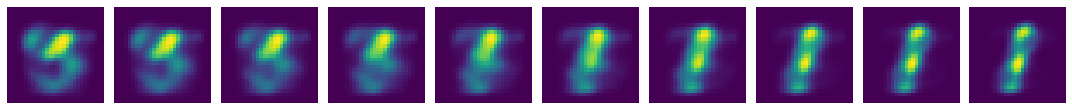

In [ ]:
plot_images_two_points(generator)style_transfer

**Виден переход от цифры 3 к цифре 1**

In [ ]:
z_imgs = models["encoder"].predict(xTest[:500], batch_size=batch_size)
print(z_imgs.shape)

(500, 10)


In [ ]:
def plot_images_two_points2(generator, z_imgs, examples=10, dim=(10,10), figsize=(15,15)):
  index1 = int(round(200*np.random.sample(1)[0]))         # Первый индекс случайно сгенерированное значение
  index2 = int(round(200*np.random.sample(1)[0]))         # Второй индекс случайно сгенерированное значение
  noise1 = z_imgs[index1, :].reshape(1,10)                # Первая зашумленная картинка по полученному индексу
  noise2 = z_imgs[index2, :].reshape(1,10)                # Вторая зашумленная картинка по полученному индексу

  # Получаем плавный переход
  im_arr = [generator.predict(i*noise2 / (examples-1) + (examples-i-1)*noise1/(examples-1)) for i in range(examples)]
  im_arr = np.array(im_arr).reshape(examples,28,28)

  plt.figure(figsize=figsize)
  for i in range(im_arr.shape[0]):
    plt.subplot(dim[0], dim[1], i+1)
    plt.imshow(im_arr[i], interpolation='nearest')
    plt.axis('off')
  plt.tight_layout()

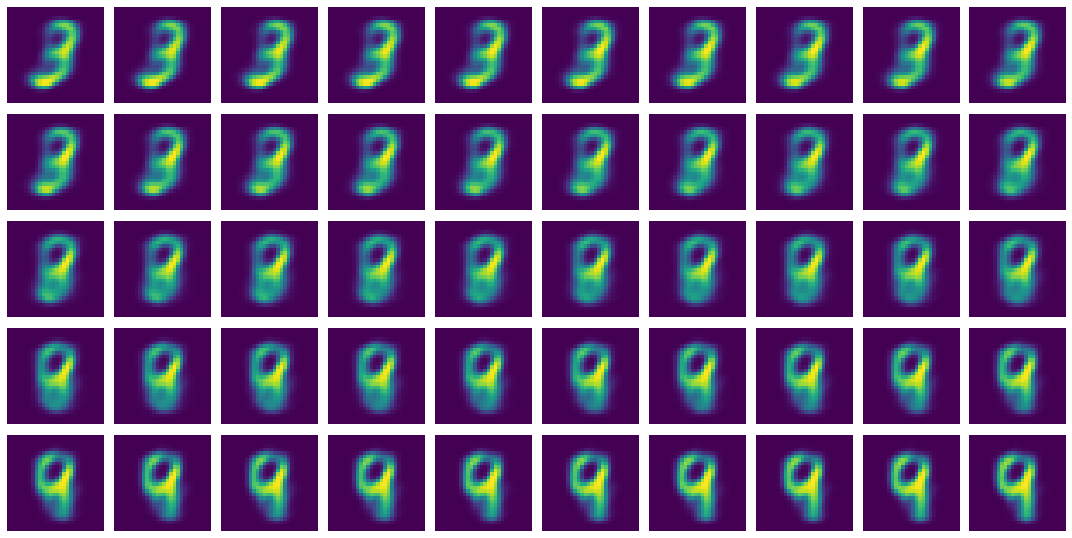

In [ ]:
plot_images_two_points2(generator, z_imgs, examples=50)

**Здесь видим плавный переход от цифры 3 к цифре 9**

# Визуализируем скрытое пространство

In [ ]:
# Задаем размер скрытого пространства
latent_dim = 2

In [ ]:
# Снова компилируем модель
vae.compile(optimizer=Adam(start_lr), loss=vae_loss)

## Обучение сети

In [ ]:
vae.fit(xTrain, xTrain, shuffle=True, epochs=10, batch_size=batch_size, validation_data=(xTest, xTest), verbose=1)

Train on 60000 samples, validate on 10000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
60000/60000 [==============================] - 19s 319us/sample - loss: 0.3442 - val_loss: 0.2496
Epoch 2/10
60000/60000 [==============================] - 18s 298us/sample - loss: 0.1941 - val_loss: 0.1294
Epoch 3/10
60000/60000 [==============================] - 17s 292us/sample - loss: 0.1311 - val_loss: 0.1082
Epoch 4/10
60000/60000 [==============================] - 17s 289us/sample - loss: 0.1164 - val_loss: 0.1008
Epoch 5/10
60000/60000 [==============================] - 17s 290us/sample - loss: 0.1094 - val_loss: 0.0959
Epoch 6/10
60000/60000 [==============================] - 18s 294us/sample - loss: 0.1045 - val_loss: 0.0921
Epoch 7/10
60000/60000 [==============================] - 17s 290us/sample - loss: 0.1012 - val_loss: 0.0895
Epoch 8/10
60000/60000 [==============================] - 18s 292us/sample - loss: 0.0988 - val_loss: 0.0878
Epoch 9/10
60000/60000 [======

In [ ]:
encoder_sigma = models["z_lvarer"]                               # Модель для получения логарифма дисперсии
encoder_sigma = encoder_sigma.predict(xTest[:1000], batch_size)  # Получаем значения логарифма дисперсии
encoder_sigma = np.sqrt(np.exp(encoder_sigma))                   # Достаем из логарифма дисперсии значение отклонения

encoder_mean = models["z_meaner"]                                # Модель для получения среднего
encoder_mean = encoder_mean.predict(xTest[:1000], batch_size)    # Получаем значения среднего

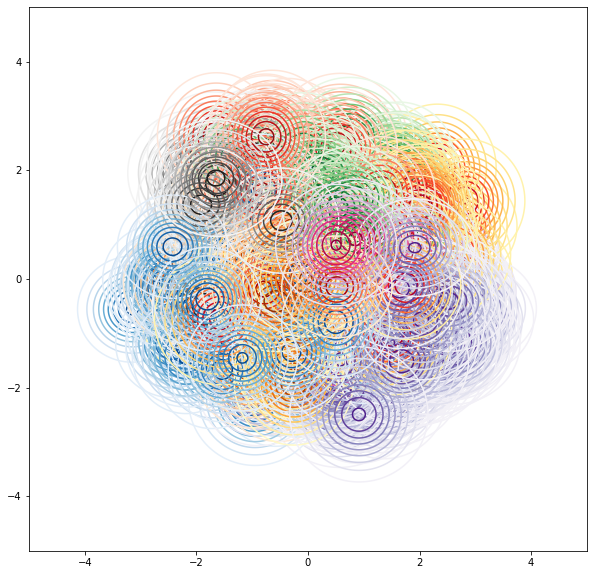

In [ ]:
# Список для раскраски каждого класса разными цветами
colorss = ["Greys", "Purples", "Blues", "Greens", "Oranges", "Reds", "YlOrBr", "YlOrRd", "OrRd", "PuRd"]

plt.figure(figsize=(10,10))
for i in range(len(encoder_mean)):
  x = np.linspace(encoder_mean[i][0]-10*encoder_sigma[i][0], encoder_mean[i][0]+10*encoder_sigma[i][0], 500)
  y = np.linspace(encoder_mean[i][1]-10*encoder_sigma[i][0], encoder_mean[i][1]+10*encoder_sigma[i][1], 500)
  X, Y = np.meshgrid(x,y)
  pos = np.empty(X.shape + (2,))
  pos[:, :, 0] = X
  pos[:, :, 1] = Y

  rv = multivariate_normal([encoder_mean[i][0], encoder_mean[i][1]], [[encoder_sigma[i][0], 0], [0, encoder_sigma[i][1]]])
  plt.contour(X, Y, rv.pdf(pos), 10, cmap=colorss[int(yTest[i])])

plt.xlim(-5,5)
plt.ylim(-5,5)
plt.show()

**Попробуем дообучить сеть еще на 10 эпохах и посмотреть как изменится вывод**

In [ ]:
vae.fit(xTrain, xTrain, shuffle=True, epochs=20, batch_size=batch_size, validation_data=(xTest, xTest), verbose=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 19s 325us/sample - loss: 0.0880 - val_loss: 0.0776
Epoch 2/20
60000/60000 [==============================] - 18s 299us/sample - loss: 0.0881 - val_loss: 0.0776
Epoch 3/20
60000/60000 [==============================] - 18s 294us/sample - loss: 0.0879 - val_loss: 0.0777
Epoch 4/20
60000/60000 [==============================] - 18s 296us/sample - loss: 0.0880 - val_loss: 0.0776
Epoch 5/20
60000/60000 [==============================] - 18s 297us/sample - loss: 0.0879 - val_loss: 0.0776
Epoch 6/20
60000/60000 [==============================] - 18s 300us/sample - loss: 0.0878 - val_loss: 0.0775
Epoch 7/20
60000/60000 [==============================] - 18s 299us/sample - loss: 0.0879 - val_loss: 0.0775
Epoch 8/20
60000/60000 [==============================] - 18s 301us/sample - loss: 0.0879 - val_loss: 0.0774
Epoch 9/20
60000/60000 [==============================] - 18s 299us/sample - l

In [ ]:
encoder_sigma = models["z_lvarer"]                               # Модель для получения логарифма дисперсии
encoder_sigma = encoder_sigma.predict(xTest[:1000], batch_size)  # Получаем значения логарифма дисперсии
encoder_sigma = np.sqrt(np.exp(encoder_sigma))                   # Достаем из логарифма дисперсии значение отклонения

encoder_mean = models["z_meaner"]                                # Модель для получения среднего
encoder_mean = encoder_mean.predict(xTest[:1000], batch_size)    # Получаем значения среднего

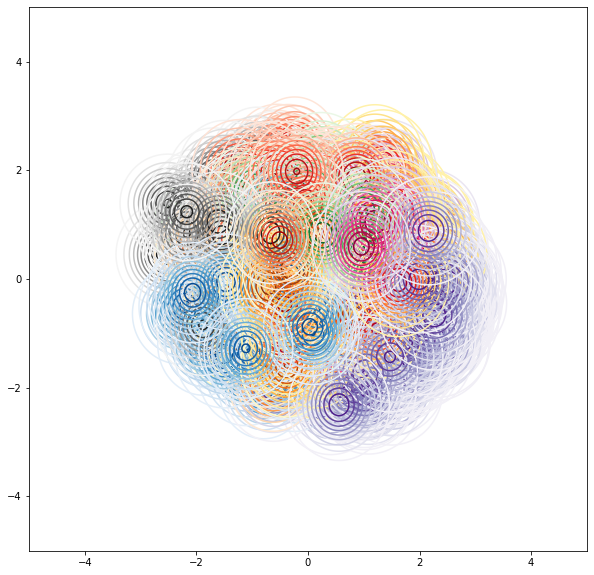

In [ ]:
plt.figure(figsize=(10,10))
for i in range(len(encoder_mean)):
  x = np.linspace(encoder_mean[i][0]-10*encoder_sigma[i][0], encoder_mean[i][0]+10*encoder_sigma[i][0], 500)
  y = np.linspace(encoder_mean[i][1]-10*encoder_sigma[i][0], encoder_mean[i][1]+10*encoder_sigma[i][1], 500)
  X, Y = np.meshgrid(x,y)
  pos = np.empty(X.shape + (2,))
  pos[:, :, 0] = X
  pos[:, :, 1] = Y

  rv = multivariate_normal([encoder_mean[i][0], encoder_mean[i][1]], [[encoder_sigma[i][0], 0], [0, encoder_sigma[i][1]]])
  plt.contour(X, Y, rv.pdf(pos), 10, cmap=colorss[int(yTest[i])])

plt.xlim(-5,5)
plt.ylim(-5,5)
plt.show()

# CVAE (Вариационный автокодировщик c условием)

## Загрузка данных

In [ ]:
(xTrain, yTrain), (xTest, yTest) = mnist.load_data()

## Нормализация и категоризация

In [ ]:
# Нормализация
xTrain = xTrain.astype('float32') / 255.
xTest  = xTest .astype('float32') / 255. 
xTrain = np.reshape(xTrain, (len(xTrain), 28, 28, 1)) 
xTest  = np.reshape(xTest,  (len(xTest),  28, 28, 1)) 

# Категоризация
yTrainCat = to_categorical(yTrain, 10).astype(np.float32)  # Переводим обучающие лейблы в one-hot кодировку
yTestCat  = to_categorical(yTest, 10).astype(np.float32)   # Переводим проверочные лейблы в one-hot кодировку
num_classes = yTestCat.shape[1]                            # Задаем количество классов

In [ ]:
print("xTrain: ",    xTrain.shape)
print("xTest: ",     xTest.shape)
print("yTrainCat: ", yTrainCat.shape)
print("yTestCat: ",  yTestCat.shape)

xTrain:  (60000, 28, 28, 1)
xTest:  (10000, 28, 28, 1)
yTrainCat:  (60000, 10)
yTestCat:  (10000, 10)


## Создание функций и моделей

In [ ]:
# Зададим константы
batch_size = 500      # Размер batch_size
latent_dim = 8        # Размер скрытого пространства
dropout_rate = 0.3    # Размер слоя Dropount, сколько выключаем нейронов
start_lr = 0.001     # Задаем шаг обучения

In [ ]:
# Функция создания вариационного автокодировщика c условием
def create_cvae(): 
  models = {}

  # Функция Dropout и BatchNormalization
  def apply_bn_and_dropout(x):                                 # На вход принимает слой (x)
    return Dropout(dropout_rate)(BatchNormalization()(x))      # Возвращает 2 слоя

  # Энкодер
  input_img = Input(shape=(28,28,1))
  flatten_img = Flatten()(input_img)
  input_lbl = Input(shape=(num_classes,), dtype='float32')      # Второй вход в энкодер с учетом лейблов и по количеству классов

  x = concatenate([flatten_img, input_lbl])                    # Конкатенируем входы 

  x = Dense(256, activation='relu')(x)

  x = apply_bn_and_dropout(x)

  # Предсказываем параметры распределений

  z_mean = Dense(latent_dim)(x)                                # скрытое пространство(мат.ожидание)
  z_log_var = Dense(latent_dim)(x)                             # скрытое пространство(лог.вариации)

  # Сэмплирование 
  def sampling(args):                                          # Объявляем функцию сэмплирования
    z_mean, z_log_var = args                                   # принимаем в аргументах z_mean, z_log_var

    # Нормальное распределение
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.0)
    return z_mean + K.exp(z_log_var / 2) * epsilon
  
  # Задаем самописный слой
  l  = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

  models["encoder"]  = Model([input_img, input_lbl], l)         # Модель энкодера от входа до лямда слоя
  models["z_meaner"] = Model([input_img, input_lbl], z_mean)    # Модель от входа до z_mean
  models["z_lvarer"] = Model([input_img, input_lbl], z_log_var) # Модель от входа до z_log_var

  # Декодер
  z = Input(shape=(latent_dim, ))                               # Первая входная размерность (8,)
  input_lbl_d = Input(shape=(num_classes,), dtype='float32')    # Вторая входная размерность по номеру классов
  x = concatenate([z, input_lbl_d])
  x = Dense(256)(x)
  x = LeakyReLU()(x)
  x = Dense(28*28, activation='sigmoid')(x)
  decoded = Reshape((28,28,1))(x)

  # Cобираем модель декодера
  models["decoder"] = Model([z, input_lbl_d], decoded, name='Decoder')

  # Cобираем вариационный автокодировщик с условием(3 input на входе, затем первые два проходят через энкодер,
  # складываются с input_lbl_d и всё это проходит через декодер на выходе)
  models["cvae"] = Model([input_img, input_lbl, input_lbl_d], 
                         models["decoder"]([models["encoder"]([input_img, input_lbl]), input_lbl_d]), name="CVAE")
  
  # Вместо энкодера модель z_meaner
  models["style_t"] = Model([input_img, input_lbl, input_lbl_d], 
                            models["decoder"]([models["z_meaner"]([input_img, input_lbl]), input_lbl_d]), name="style_transfer")
  
  # Cамописная функция потерь
  def vae_loss(x, decoded): 
    x = K.reshape(x, shape=(batch_size, 28*28))                                          
    decoded = K.reshape(decoded, shape=(batch_size, 28*28))                               
    xent_loss = 28 * 28 * binary_crossentropy(x, decoded)                                 
    kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)  
    return (xent_loss + kl_loss) / 2 / 28 / 28

  return models, vae_loss                                            

In [ ]:
# Получение модели и свою функции потерь
models, vae_loss = create_cvae()

In [ ]:
# Задаем модель
cvae = models["cvae"]

In [ ]:
# Компилируем модель
cvae.compile(optimizer=Adam(start_lr), loss=vae_loss)

**Не смотря на то, что данная функция уже была объявлена выше, можно ее написать еще раз ради практики.**

In [ ]:
# Функция отрисовки двух линий картинок - оригинальные и выходные из автокодировщика

digit_size = 28   # Задаем размер цифр

def plot_digits(*args, invert_colors=False):
  args = [x.squeeze() for x in args]                          # Удаляем оси с одним элементом из аргументов
  n = min([x.shape[0] for x in args])                         # Берем минимальное от нулевой оси x'ов в аргументах
  figure = np.zeros((digit_size * len(args), digit_size * n)) # Cоздаем фигуру с использованием массива нулей по заданным размерам

  for i in range(n):
    for j in range(len(args)):                                # Заполняем фигуру значениями
      figure[j * digit_size: (j + 1) * digit_size,
             i * digit_size: (i + 1) * digit_size] = args[j][i].squeeze()
  
  if invert_colors:                                           # Если значение invert_colors будет True
    figure = 1 - figure                                       # Инвертируем фигуру
  
  plt.figure(figsize=(2*n, 2*len(args)))                      # Задаем фигуру
  plt.imshow(figure, cmap='Greys_r')                          # Вывод в указанном цвете Greys_r
  plt.grid(False)                                             # Отключаем сетку
  ax = plt.gca()                                              # Получаем текущий объект Axes
  ax.get_xaxis().set_visible(False)                           # Ось координат x делаем невидимой
  ax.get_yaxis().set_visible(False)                           # Ось координат y делаем невидимой
  plt.show()

# Картинка с 15x15 цифр
n = 15 

In [ ]:
# Эпохи, в которые будем сохранять
save_epochs = set([i*5 for i in range(0,25)])

In [ ]:
# Отслеживать будем на вот этих цифрах
imgs = xTest[:batch_size]
imgs_lbls = yTestCat[:batch_size]
n_compare = 10

In [ ]:
# Модели
generator = models["decoder"]
encoder_mean = models['z_meaner']

In [ ]:
# Callback
def on_epoch_end(epoch, logs):
  if epoch in save_epochs:
    clear_output()

    # Сравнение реальных и декодированных цифр
    decoded = cvae.predict([imgs, imgs_lbls, imgs_lbls], batch_size=batch_size)
    plot_digits(imgs[:n_compare], decoded[:n_compare])


In [ ]:
pltfig = LambdaCallback(on_epoch_end = on_epoch_end)
tb = TensorBoard(log_dir='./logs')

## Обучение

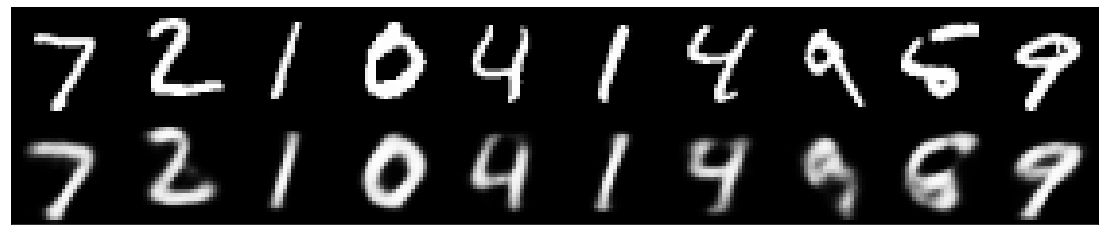

60000/60000 [==============================] - 11s 191us/sample - loss: 0.0772 - val_loss: 0.0746
Epoch 17/20
60000/60000 [==============================] - 11s 188us/sample - loss: 0.0768 - val_loss: 0.0742
Epoch 18/20
60000/60000 [==============================] - 11s 189us/sample - loss: 0.0765 - val_loss: 0.0738
Epoch 19/20
60000/60000 [==============================] - 11s 186us/sample - loss: 0.0761 - val_loss: 0.0736
Epoch 20/20
60000/60000 [==============================] - 11s 185us/sample - loss: 0.0758 - val_loss: 0.0732


In [ ]:
cvae.fit([xTrain, yTrainCat, yTrainCat], xTrain, shuffle=True, epochs=20, batch_size=batch_size, validation_data=([xTest, yTestCat, yTestCat], xTest), callbacks=[pltfig, tb], verbose=1)

## Результат обучения



In [ ]:
# Объявляем функцию переноса стилей
def style_transfer(model, X, lbl_in, lbl_out):
  rows = X.shape[0]
  if isinstance(lbl_in, int):                 # Входные лейблы(энкодера), если это тип int
    lbl = lbl_in
    lbl_in = np.zeros((rows, 10))
    lbl_in[:, lbl] = 1                        # заполняем в нужную строчку единицу
  
  if isinstance(lbl_out, int):                # Выходные лейблы(энкодера), если это тип int
    lbl = lbl_out
    lbl_out = np.zeros((rows,10))
    lbl_out[:, lbl] = 1
  
  return model.predict([X, lbl_in, lbl_out])  # Возврат предсказанных картинок

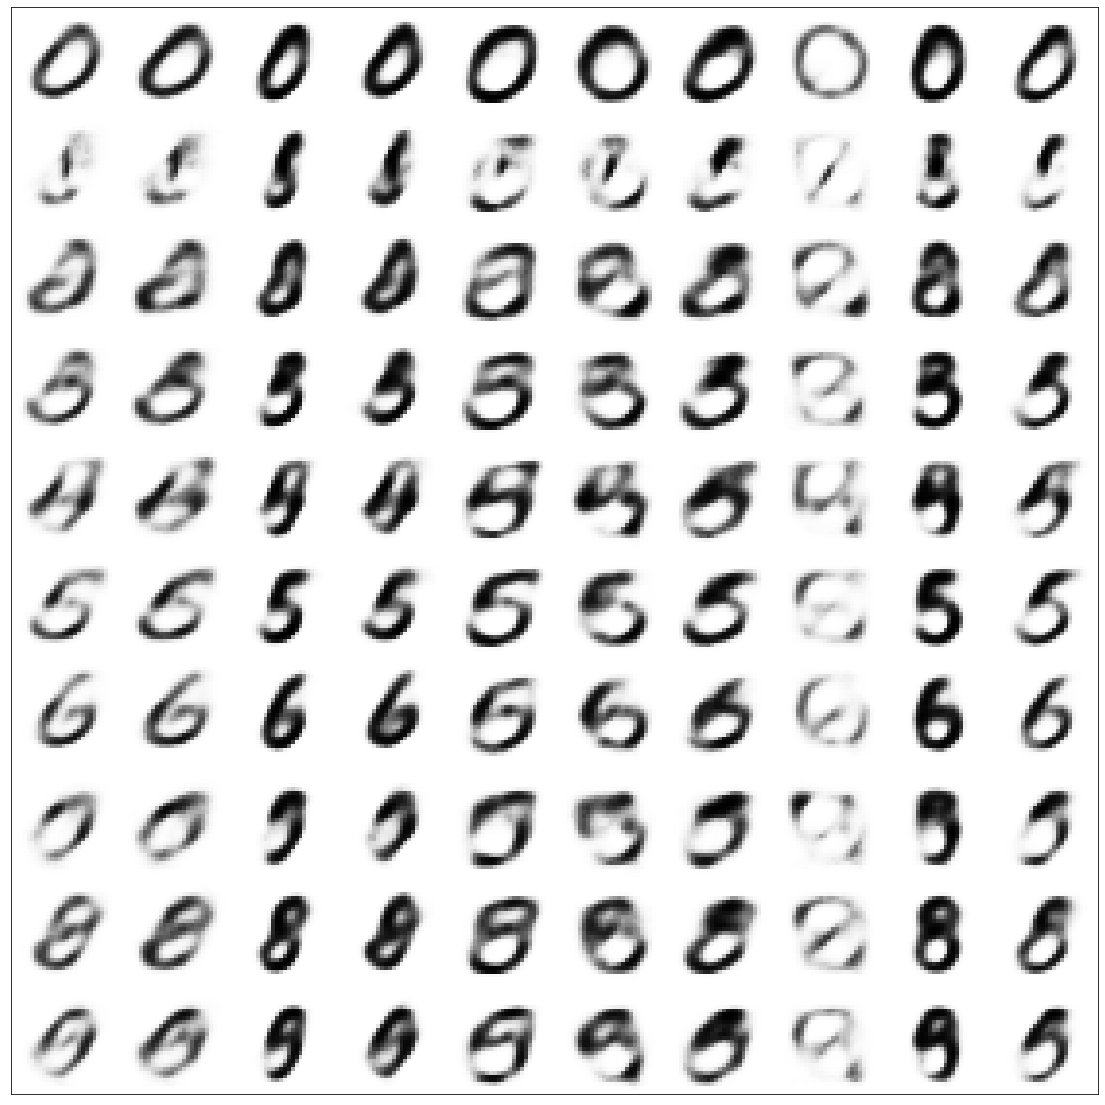

In [ ]:
n = 10          # Выбираем количество картинок
lbl = 0         # Выбираем лейбл

generated = []  # список сгенерированных картинок
prot = xTrain[yTrain==lbl][:n]

for i in range(num_classes):
  generated.append(style_transfer(models["style_t"], prot, lbl, i))    # Генериhetv картинки с учетом переноса стиля

plot_digits(*generated, invert_colors=True)

# Дополнительно VAE (ООП)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Создание слоя sampling

In [ ]:
class Sampling(layers.Layer):
  def call(self, inputs):
    z_mean, z_log_var = inputs
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5*z_log_var) * epsilon

## Создание encoder

In [ ]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))

x = Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = Flatten()(x)
x = Dense(16, activation="relu")(x)

z_mean = Dense(latent_dim, name="z_mean")(x)
z_log_var = Dense(latent_dim, name="z_log_var")(x)

z = Sampling()([z_mean, z_log_var])

encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

In [ ]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 7, 7, 64)     18496       conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 3136)         0           conv2d_1[0][0]                   
____________________________________________________________________________________________

## Создание decoder

In [ ]:
latent_inputs = Input(shape=(latent_dim,))

x = Dense(7*7*64, activation='relu')(latent_inputs)
x = Reshape((7,7,64))(x)
x = Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
x = Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)

decoder_outputs = Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)

decoder = Model(latent_inputs, decoder_outputs, name='decoder')

In [ ]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_3 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 1)         289       
Total params: 65,089
Trainable params: 65,089
Non-trainable params: 0
_______________________________________________________

## Определение VAE как модель с настраиваемым train_step

In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


## Загрузка данных

In [ ]:
(xTrain, yTrain), (xTest, yTest) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
mnist_digits = np.concatenate([xTrain, xTest], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype('float32') / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=Adam())

## Обучение

In [ ]:
vae.fit(mnist_digits, epochs=30, batch_size=128)

Epoch 1/30
547/547 [==============================] - 41s 18ms/step - loss: 252.9852 - reconstruction_loss: 199.4850 - kl_loss: 4.4139
Epoch 2/30
547/547 [==============================] - 10s 18ms/step - loss: 171.6904 - reconstruction_loss: 163.6642 - kl_loss: 5.8514
Epoch 3/30
547/547 [==============================] - 10s 18ms/step - loss: 164.5994 - reconstruction_loss: 157.1980 - kl_loss: 6.0620
Epoch 4/30
547/547 [==============================] - 10s 18ms/step - loss: 160.3852 - reconstruction_loss: 153.7238 - kl_loss: 6.2196
Epoch 5/30
547/547 [==============================] - 10s 18ms/step - loss: 158.3087 - reconstruction_loss: 151.5375 - kl_loss: 6.2997
Epoch 6/30
547/547 [==============================] - 10s 18ms/step - loss: 156.8274 - reconstruction_loss: 150.1785 - kl_loss: 6.3822
Epoch 7/30
547/547 [==============================] - 10s 18ms/step - loss: 155.7971 - reconstruction_loss: 149.0439 - kl_loss: 6.4118
Epoch 8/30
547/547 [==============================] - 1

## Отображение сетки выбранных цифр

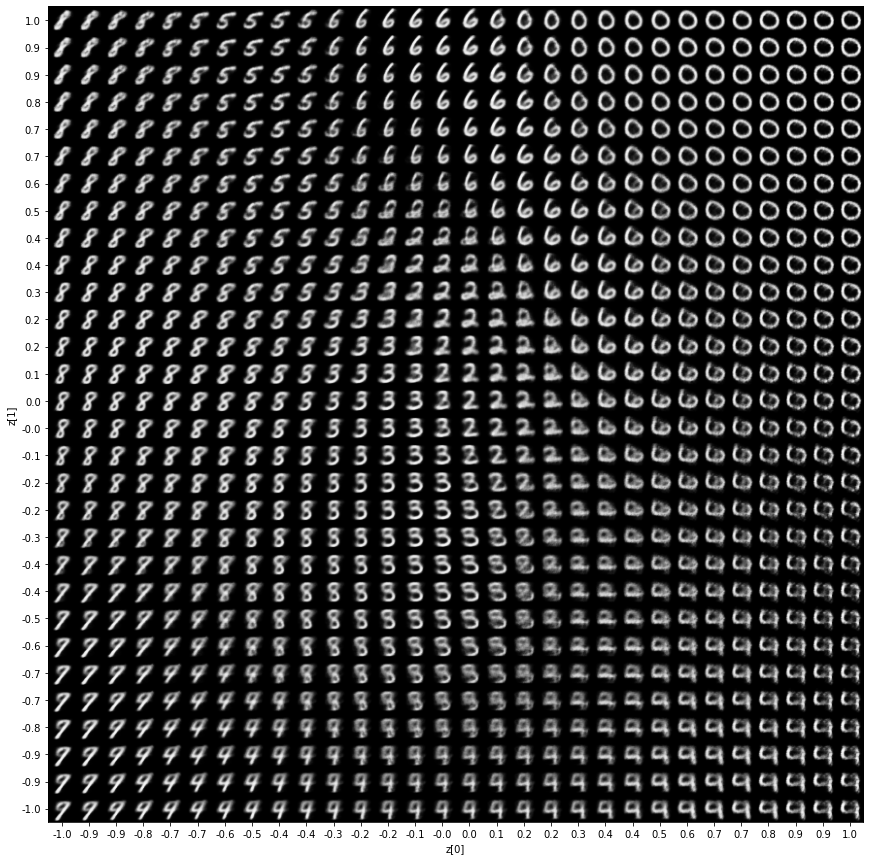

In [ ]:
def plot_latent_space(vae, n=30, figsize=15):
    
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae)

## Функция группировки разных классов цифр

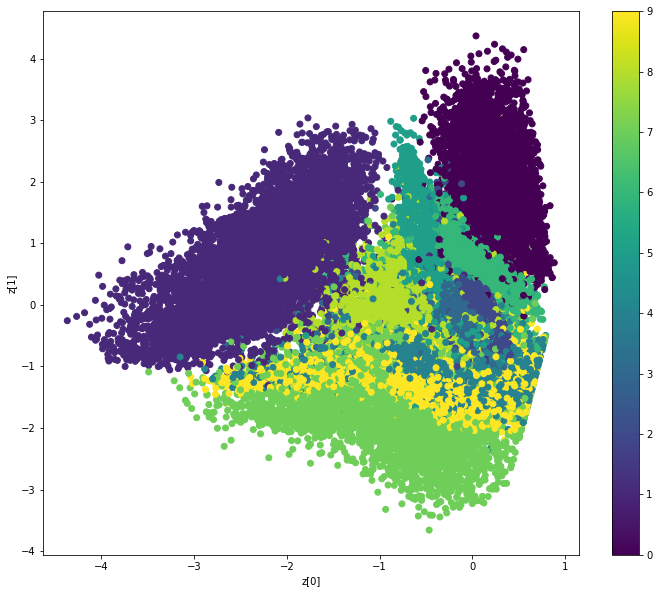

In [ ]:
def plot_label_clusters(vae, data, labels):
    
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(vae, x_train, y_train)

# Выводы:

1. Весь ноутбук переписывался в ручную что является хорошей практикой.

2. В этом домашнем задание было изучено:
  - Зачем нужны вариационные автокодировщики
  - Отличие от простых Автокодировщиков
  - Как с помощью Вариационных автокодировщиков можно решить проблемы обычных Автокодировщиков.

3. По мимо основной задачи  было выполнено задание Вариационный автокодировщик с помощью ООП.

4. К одной задаче может быть множество подходхов.